# Imports

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.utils as vision_utils
from scipy.stats import truncnorm
import torchvision
from matplotlib.ticker import NullFormatter
import copy
from typing import Any, Callable, List, Optional, Type, Union


DEVICE = torch.device('cuda:3')

/users/ug21/divsinghal/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gc
import random
import os
def seed_everything(seed: int):
   # This is a utility function you can use for all your ML applications
   # More generic than you would need for this particular assignment
   gc.collect()
   torch.cuda.empty_cache()
   random.seed(seed)
   os.environ['PYTHONHASHSEED'] = str(seed)
   torch.manual_seed(seed)
   torch.cuda.manual_seed(seed)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False
seed_everything(200)

classes_nums = [2,5,10,20,50]
# alphas = [0.001,0.001,0.001,0.001,0.001]
alphas = [0.005]*5

# Fetch CIFAR100


In [3]:
def plot_samples(dataset, nrow=13, figsize=(10,7)):
  try:
    X, Y = dataset.tensors
  except:
    try:
      (X,) = dataset.tensors
    except:
      X = dataset
  fig = plt.figure(figsize=figsize, dpi=130)
  grid_img = vision_utils.make_grid(X[:nrow].cpu(), nrow=nrow, normalize=True, padding=1)
  _ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
  _ = plt.tick_params(axis=u'both', which=u'both',length=0)
  ax = plt.gca()
  _ = ax.xaxis.set_major_formatter(NullFormatter())
  _ = ax.yaxis.set_major_formatter(NullFormatter())
  plt.show()

In [4]:
def get_pytorch_dataset(dataset, device, classes_to_keep=None):
  X, Y = [], []
  for x, y in dataset:
    if classes_to_keep is not None and y in classes_to_keep:
      X.append(torch.tensor(x))
      Y.append(y)
    elif classes_to_keep is None:
      X.append(torch.tensor(x))
      Y.append(y)
  X = torch.stack(X).to(device)
  Y = torch.tensor(Y).long().to(device)
  return TensorDataset(X, Y)

Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_1619242/1447088094.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X.append(torch.tensor(x))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


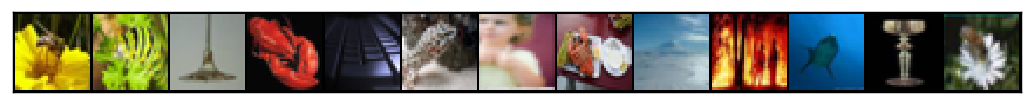

In [5]:
train_datas = []
test_datas = []
valid_datas = []
train_dls = []
valid_dls = []
test_dls = []
for num_classes in classes_nums :
  train_data = CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
  test_data = CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

  train_data, valid_data = random_split(train_data, [45000, 5000])

  train_data = get_pytorch_dataset(train_data, DEVICE, classes_to_keep=range(num_classes))
  valid_data = get_pytorch_dataset(valid_data, DEVICE, classes_to_keep=range(num_classes))
  test_data = get_pytorch_dataset(test_data, DEVICE, classes_to_keep=range(num_classes))

  train_dl = DataLoader(train_data, batch_size=256, shuffle=True)
  valid_dl = DataLoader(valid_data, batch_size=1024, shuffle=False)
  test_dl  = DataLoader(test_data, batch_size=1024, shuffle=False)
  train_datas.append(train_data)
  test_datas.append(test_data)
  valid_datas.append(valid_dl)
  train_dls.append(train_dl)
  valid_dls.append(valid_dl)
  test_dls.append(test_dl)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print(f"Train size: {len(train_dl.dataset)}")
# print(f"Valid size: {len(valid_dl.dataset)}")
# print(f"Test size: {len(test_dl.dataset)}")

plot_samples(train_data)

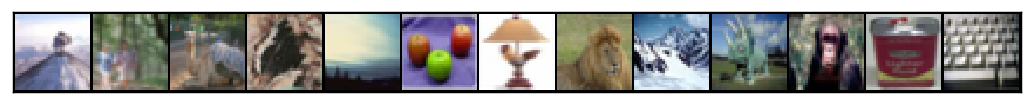

In [6]:
plot_samples(test_data)


# Get $\mathcal{D}_\text{ood}$

Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_1619242/1447088094.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X.append(torch.tensor(x))


OOD size: 1200
Files already downloaded and verified
Files already downloaded and verified
OOD size: 3000
Files already downloaded and verified
Files already downloaded and verified
OOD size: 6000
Files already downloaded and verified
Files already downloaded and verified
OOD size: 12000
Files already downloaded and verified
Files already downloaded and verified
OOD size: 30000


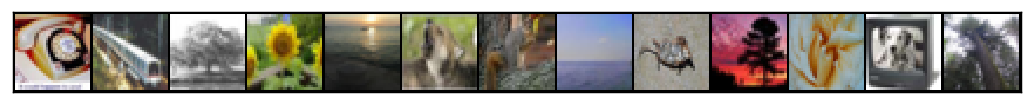

In [7]:
perturb_dls = []
for num_classes in classes_nums :
  train_data = CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
  test_data = CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

  train_data = get_pytorch_dataset(train_data, DEVICE, classes_to_keep=range(50, 50+num_classes))
  test_data = get_pytorch_dataset(test_data, DEVICE, classes_to_keep=range(50, 50+num_classes))

  X_train, Y_train = train_data.tensors
  X_test, Y_test = test_data.tensors

  perturb_data = TensorDataset(torch.cat((X_train, X_test)), torch.cat((Y_train, Y_test)))

  perturb_dl = DataLoader(perturb_data, batch_size=256, shuffle=True)
  perturb_dls.append(perturb_dl)

  print(f"OOD size: {len(perturb_dl.dataset)}")

plot_samples(perturb_data)

# Fetch CIFAR100

In [8]:
# test_data_c100 = CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

# test_data_c100 = get_pytorch_dataset(test_data_c100, DEVICE)

# test_dl_c100  = DataLoader(test_data_c100, batch_size=1024, shuffle=False)

# print(f"Test size: {len(test_dl_c100.dataset)}")

# plot_samples(test_data_c100)

# Model

This is a ResNet-18 with added dropout for MC-dropout. The fist convolution (conv1) is modified for better results on CIFAR-10:
* `kernel_size`: 7 --> 3
* `stride`: 2 --> 1
* `padding`: 3 -->1

The method `model.set_sample(True)` can be used to keep using dropout even with the model in eval mode (to prevent updating batch-norm parameters).

# Utils

In [9]:
@torch.no_grad()
def get_acc(model, dl): # Eval without dropout
  model.eval()
  # model.set_sample(False)
  acc = []
  for X, y in dl:
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  # model.set_sample(True)
  return acc.item()


@torch.no_grad()
def get_ensemble_acc(models, dl): # Eval without dropout, eval the ensemble
  for model in models:
    model.eval()
    # model.set_sample(False)
  acc = []
  for X, y in dl:
    outs = [torch.softmax(model(X), dim=1) for model in models]
    outs = torch.stack(outs, dim=0).mean(dim=0)
    acc.append(torch.argmax(outs, dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  for model in models:
    model.train()
    # model.set_sample(True)
  return acc.item()


@torch.no_grad()
def get_probas_mcd(model, dl, num_samples=10, use_dropout=True):
  # return the proabilities for samples using MC-dropout (unless use_dropout=False)
  model.eval()
  # model.set_sample(use_dropout)
  probs = []
  for X, y in dl:
    outs = [model(X) for x in range(num_samples)]
    ps = [torch.softmax(out, dim=1) for out in outs]
    mean_ps = torch.stack(ps).mean(dim=0)
    probs.append(mean_ps)
  probs = torch.cat(probs)
  return probs


@torch.no_grad()
def get_probas_ensemble(models, dl):
  for model in models:
    model.eval()
    # model.set_sample(False)
  probs = []
  for X, y in dl:
    outs = [model(X) for model in models]
    ps = [torch.softmax(out, dim=1) for out in outs]
    mean_ps = torch.stack(ps).mean(dim=0)
    probs.append(mean_ps)
  probs = torch.cat(probs)
  return probs


def plot_hist(probas):
  fig, (ax) = plt.subplots(1,1,figsize=(3,3), dpi=110)

  ax.grid()

  ax.set_xlabel("largest probability")
  ax.set_ylabel("Number of datapoints")

  _ = ax.hist(probas, bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], linestyle='solid', color='g')
  ax.set_xlim(0, 1)

# Training utils

In [10]:
import torchvision.models as model_zoo
def dl_to_sampler(dl):
  dl_iter = iter(dl)
  def sample():
    nonlocal dl_iter
    try:
      return next(dl_iter)
    except StopIteration:
      dl_iter = iter(dl)
      return next(dl_iter)
  return sample

def m_f(num_classes=2):
    m = model_zoo.resnet18(pretrained=True)
    d = m.fc.in_features
    m.fc = nn.Linear(d, num_classes)
    return m.to(DEVICE)

def sequential_train(num_models, train_dl, valid_dl, perturb_dl, alpha=1, max_epoch=30,
                     use_diversity_reg=True, lr=0.2, weight_decay=1e-5, dropout=0.2,num_classes=2):
  seed_everything(200)
  models = [m_f(num_classes=num_classes) for _ in range(num_models)]

  stats = {f"m{i+1}": {"acc": [], "loss": [], "adv-loss": []} for i in range(len(models))}

  for m_idx, m in enumerate(models):

    for m_ in models[:m_idx]:
      m_.eval()
      # m.set_sample(False)

    opt = torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, 0, lr, step_size_up=(len(train_dl)*max_epoch)//2, mode='triangular', cycle_momentum=False)

    perturb_sampler = dl_to_sampler(perturb_dl)

    for epoch in range(max_epoch):
      for itr, (x, y) in enumerate(train_dl):
        (x_tilde,  _) = perturb_sampler()
        erm_loss = F.cross_entropy(m(x), y)

        if use_diversity_reg and m_idx != 0:
          adv_loss = []

          p_2 = torch.softmax(m(x_tilde), dim=1)
          p_2_1, max_idx = p_2.max(dim=1)
          p_2_0 = 1. - p_2_1

          with torch.no_grad():
            p_1_s = [torch.softmax(m_(x_tilde), dim=1) for m_ in models[:m_idx]]
            p_1_1_s = [p_1[torch.arange(len(p_1)), max_idx] for p_1 in p_1_s]
            p_1_0_s = [1. - p_1_1 for p_1_1 in p_1_1_s]

          for i in range(len(p_1_s)):
            al = (- torch.log(p_1_1_s[i] * p_2_0 + p_2_1 * p_1_0_s[i] +  1e-7)).mean()
            adv_loss.append(al)
        else:
          adv_loss = [torch.tensor([0]).to(DEVICE)]

        adv_loss = sum(adv_loss)/len(adv_loss)

        if use_diversity_reg and m_idx != 0:
          loss = erm_loss + alpha * adv_loss
        else:
          loss = erm_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()

        if (itr + epoch * len(train_dl)) % 200 == 0:
          itr_ = itr + epoch * len(train_dl)
          print_str = f"[m{m_idx+1}] {epoch}/{itr_} [train] loss: {erm_loss.item():.2f} adv-loss: {adv_loss.item():.2f} "
          stats[f"m{m_idx+1}"]["loss"].append((itr_, erm_loss.item()))
          stats[f"m{m_idx+1}"]["adv-loss"].append((itr_, adv_loss.item()))
          acc = get_acc(m, valid_dl)
          stats[f"m{m_idx+1}"]["acc"].append((itr_, acc))
          print_str += f" acc: {acc:.2f} "
          if itr_ != 0 and scheduler is not None:
            print_str += f"[lr] {scheduler.get_last_lr()[0]:.5f} "
          print(print_str)

        itr += 1

  stats['all_models'] = models

  return stats

# Train with D-BAT

In [11]:
statsS = []
for i in range(len(classes_nums)) :
  print(f"-------NUMBER OF CLASSES = {classes_nums[i]}--------\n")
  stats = sequential_train(4, train_dls[i], valid_dls[i], perturb_dls[i],alpha=alphas[i],
                          max_epoch=100, use_diversity_reg=True, lr=0.1,
                          weight_decay=5e-4, dropout=0.2,num_classes=classes_nums[i])
  statsS.append(stats)

-------NUMBER OF CLASSES = 2--------



/users/ug21/divsinghal/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/users/ug21/divsinghal/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[m1] 0/0 [train] loss: 0.72 adv-loss: 0.00  acc: 0.39 
[m1] 50/200 [train] loss: 0.00 adv-loss: 0.00  acc: 0.98 [lr] 0.09950 
[m2] 0/0 [train] loss: 0.86 adv-loss: 0.84  acc: 0.57 
[m2] 50/200 [train] loss: 0.22 adv-loss: 2.05  acc: 0.81 [lr] 0.09950 
[m3] 0/0 [train] loss: 0.66 adv-loss: 0.77  acc: 0.37 
[m3] 50/200 [train] loss: 0.00 adv-loss: 2.56  acc: 0.96 [lr] 0.09950 
[m4] 0/0 [train] loss: 0.99 adv-loss: 1.15  acc: 0.55 
[m4] 50/200 [train] loss: 0.00 adv-loss: 0.77  acc: 0.89 [lr] 0.09950 
-------NUMBER OF CLASSES = 5--------

[m1] 0/0 [train] loss: 1.83 adv-loss: 0.00  acc: 0.16 
[m1] 22/200 [train] loss: 0.03 adv-loss: 0.00  acc: 0.77 [lr] 0.04467 
[m1] 44/400 [train] loss: 0.06 adv-loss: 0.00  acc: 0.78 [lr] 0.08911 
[m1] 66/600 [train] loss: 0.00 adv-loss: 0.00  acc: 0.84 [lr] 0.06644 
[m1] 88/800 [train] loss: 0.00 adv-loss: 0.00  acc: 0.85 [lr] 0.02200 
[m2] 0/0 [train] loss: 1.75 adv-loss: 0.85  acc: 0.22 
[m2] 22/200 [train] loss: 0.05 adv-loss: 2.77  acc: 0.81 [lr] 0.

In [12]:
for i in range(len(classes_nums)) :
  print(f"NUMBER OF CLASSES = {classes_nums[i]} : ", end="")
  print(get_ensemble_acc(statsS[i]['all_models'], test_dls[i]))

NUMBER OF CLASSES = 2 : 0.9749999642372131
NUMBER OF CLASSES = 5 : 0.8860000371932983
NUMBER OF CLASSES = 10 : 0.8440000414848328
NUMBER OF CLASSES = 20 : 0.7580000162124634
NUMBER OF CLASSES = 50 : 0.6735999584197998


In [13]:
# for i in range(len(classes_nums)) :
#   print(f"NUMBER OF CLASSES = {classes_nums[i]} : ", end="")
#   probas_ensemble_c100 = get_probas_ensemble(stats['all_models'], test_dl_c100)
#   probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
#   plot_hist(probas_ensemble_c100)

Ensemble Size = 1

In [14]:
# print(get_ensemble_acc(stats['all_models'][:1], test_dl))
# probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:1], test_dl_c100)
# probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
# plot_hist(probas_ensemble_c100)

Ensemble Size = 2

In [15]:
# print(get_ensemble_acc(stats['all_models'][:2], test_dl))
# probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:2], test_dl_c100)
# probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
# plot_hist(probas_ensemble_c100)

Ensemble Size = 3

In [16]:
# print(get_ensemble_acc(stats['all_models'][:3], test_dl))
# probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:3], test_dl_c100)
# probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
# plot_hist(probas_ensemble_c100)

# Train without D-BAT

In [17]:
statsS = []
for i in range(len(classes_nums)) :
  print(f"-------NUMBER OF CLASSES = {classes_nums[i]}--------\n")
  stats = sequential_train(4, train_dls[i], valid_dls[i], perturb_dls[i],alpha=0,
                          max_epoch=100, use_diversity_reg=False, lr=0.1,
                          weight_decay=5e-4, dropout=0.2,num_classes=classes_nums[i])
  statsS.append(stats)

-------NUMBER OF CLASSES = 2--------

[m1] 0/0 [train] loss: 0.72 adv-loss: 0.00  acc: 0.39 
[m1] 50/200 [train] loss: 0.00 adv-loss: 0.00  acc: 0.98 [lr] 0.09950 
[m2] 0/0 [train] loss: 0.86 adv-loss: 0.00  acc: 0.57 
[m2] 50/200 [train] loss: 0.00 adv-loss: 0.00  acc: 0.99 [lr] 0.09950 
[m3] 0/0 [train] loss: 0.66 adv-loss: 0.00  acc: 0.42 
[m3] 50/200 [train] loss: 0.00 adv-loss: 0.00  acc: 0.94 [lr] 0.09950 
[m4] 0/0 [train] loss: 0.99 adv-loss: 0.00  acc: 0.56 
[m4] 50/200 [train] loss: 0.00 adv-loss: 0.00  acc: 0.96 [lr] 0.09950 
-------NUMBER OF CLASSES = 5--------

[m1] 0/0 [train] loss: 1.83 adv-loss: 0.00  acc: 0.16 
[m1] 22/200 [train] loss: 0.03 adv-loss: 0.00  acc: 0.77 [lr] 0.04467 
[m1] 44/400 [train] loss: 0.06 adv-loss: 0.00  acc: 0.78 [lr] 0.08911 
[m1] 66/600 [train] loss: 0.00 adv-loss: 0.00  acc: 0.84 [lr] 0.06644 
[m1] 88/800 [train] loss: 0.00 adv-loss: 0.00  acc: 0.85 [lr] 0.02200 
[m2] 0/0 [train] loss: 1.75 adv-loss: 0.00  acc: 0.24 
[m2] 22/200 [train] loss: 

In [18]:
for i in range(len(classes_nums)) :
  print(f"NUMBER OF CLASSES = {classes_nums[i]} : ", end="")
  print(get_ensemble_acc(statsS[i]['all_models'], test_dls[i]))

NUMBER OF CLASSES = 2 : 0.98499995470047
NUMBER OF CLASSES = 5 : 0.8700000643730164
NUMBER OF CLASSES = 10 : 0.8470000624656677
NUMBER OF CLASSES = 20 : 0.7570000290870667
NUMBER OF CLASSES = 50 : 0.6721999645233154


In [19]:
# probas_ensemble_c100 = get_probas_ensemble(stats['all_models'], test_dl_c100)
# probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
# plot_hist(probas_ensemble_c100)

Ensemble Size = 1

In [20]:
# print(get_ensemble_acc(stats['all_models'][:1], test_dl))
# probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:1], test_dl_c100)
# probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
# plot_hist(probas_ensemble_c100)

Ensemble Size = 2

In [21]:
# print(get_ensemble_acc(stats['all_models'][:2], test_dl))
# probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:2], test_dl_c100)
# probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
# plot_hist(probas_ensemble_c100)

Ensemble Size = 3

In [22]:
# print(get_ensemble_acc(stats['all_models'][:3], test_dl))
# probas_ensemble_c100 = get_probas_ensemble(stats['all_models'][:3], test_dl_c100)
# probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
# plot_hist(probas_ensemble_c100)

In [23]:
# print(model_zoo.resnet18(pretrained=True,num_classes=10))